In [ ]:
Quantas retiradas de barra é bom
melhor seção

In [1]:
import sys
sys.path.insert(0, '../')
import fconcrete as fc
import matplotlib.pyplot as plt
from pytest import approx
import numpy as np
np.set_printoptions(precision=4, suppress=True, linewidth=3000)
from math import sin, tan,  pi
from fconcrete.helpers import cond
import copy

In [2]:
material = fc.Concrete('20 MPa', 1)
section = fc.Rectangle(25,60)

f1 = fc.Load.UniformDistributedLoad(-0.1622, x_begin=0, x_end=113)
f2 = fc.Load.UniformDistributedLoad(-0.4994, x_begin=113, x_end=583)
f3 = fc.Load.UniformDistributedLoad(-0.4196, x_begin=583, x_end=1188)

n1 = fc.Node.SimpleSupport(x=0, length=20)
n2 = fc.Node.SimpleSupport(x=113, length=20)
n3 = fc.Node.SimpleSupport(x=583, length=20)
n4 = fc.Node.SimpleSupport(x=1188, length=20)

bar1 = fc.BeamElement([n1, n2], section, material)
bar2 = fc.BeamElement([n2, n3], section, material)
bar3 = fc.BeamElement([n3, n4], section, material)

    
beam = fc.ConcreteBeam(
    loads = [f1, f2, f3],
    beam_elements = [bar1, bar2, bar3],
    bar_steel_max_removal = 3,
    transversal_bar_inclination_angle=90,
    available_long_steel_bars = fc.AvailableLongConcreteSteelBar(diameters=[8]),
    available_transv_steel_bars = fc.AvailableTransvConcreteSteelBar(diameters=[8])
)

In [3]:
self = beam

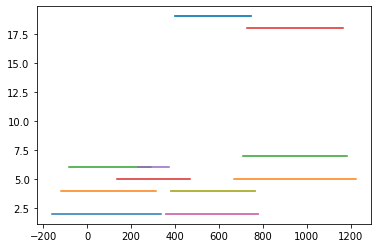

In [4]:
self.long_steel_bars.plot("quantity_accumulated")

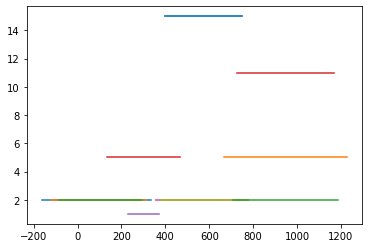

In [5]:
self.long_steel_bars.plot("quantity")

In [6]:
x=1000
positive_bars, negative_bars = self.long_steel_bars.getPositiveandNegativeLongSteelBarsInX(x=x)

In [7]:
_, beam_element = self.getBeamElementInX(x)

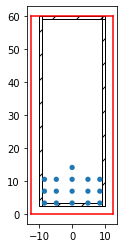

In [12]:
bars = positive_bars
#fig, ax = plt.subplots()
#ax.set_aspect("equal")

transversal_beam = self.transv_steel_bars.getTransversalBarAfterX(100)

material = beam_element.material
section = beam_element.section



x0, y0, distance_from_border = section.x0, section.y0, material.c+transversal_beam.diameter
x0_left, x0_right = x0+distance_from_border, -x0-distance_from_border

radius = max(abs(bars.diameters))
horizontal_distance = max(2, 2*radius, 1.2*self.biggest_aggregate_dimension)
vertical_distance = max(2, 2*radius, 0.5*self.biggest_aggregate_dimension)

number_of_bars = max(abs(bars.quantities_accumulated))
n = 0
bar_in_the_left = row_number =True

fig, ax = section.plot()
fig, ax = transversal_beam.plot(fig=fig, ax=ax, c=material.c)

while n<number_of_bars+1:
    
    y_row = y0+beam_element.material.c+radius*row_number+(vertical_distance+radius)*(row_number-1)
    if bar_in_the_left:
        circle = plt.Circle((x0_left+radius, y_row), radius)
        x0_left+=2*radius+horizontal_distance
    else:
        circle = plt.Circle((x0_right-radius, y_row), radius)
        x0_right-=2*radius+horizontal_distance
        
    space_between_bars = x0_right-x0_left+2*horizontal_distance
    possible_bar_in_row = (space_between_bars+horizontal_distance)//(2*radius+horizontal_distance)
    # Nao tem espaco para colcoar nenhuma depois
    if possible_bar_in_row==0:
        row_number+=1
        x0_left = x0+distance_from_border
        x0_right = -x0-distance_from_border
        bar_in_the_left = False
    elif (possible_bar_in_row==1 or n == number_of_bars) and bar_in_the_left:
        circle = plt.Circle((0, y_row), radius)
        ax.add_artist(circle)
    else:
        ax.add_artist(circle)
    n+=1
    bar_in_the_left = not bar_in_the_left



In [9]:
self.transv_steel_bars.getTransversalBarAfterX(100)

{'x': 120.0, 'height': 55.0, 'width': 20.0, 'diameter': 0.8, 'space_after': 30.0, 'area': 1.0, 'as_per_cm': 0.03333333333333333}

(<Figure size 432x288 with 1 Axes>, None)

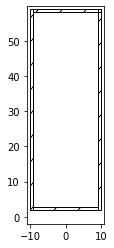

In [10]:
fig2, ax2 = self.transv_steel_bars.getTransversalBarAfterX(100).plot()

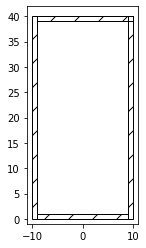

In [48]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

height = 40
width = 20
diameter = 1

c=0
x0, y0 = -width/2, c

rectangle1 = plt.Rectangle((x0,y0), diameter, c+height, hatch="/", fill=False)
rectangle2 = plt.Rectangle((x0+diameter,height-diameter+2*c), width-diameter, diameter, hatch="/", fill=False)
rectangle3 = plt.Rectangle((-x0-diameter,y0), diameter, y0+height, hatch="/", fill=False)
rectangle4 = plt.Rectangle((x0+diameter,c), width-2*diameter, diameter, hatch="/", fill=False)

ax.add_artist(rectangle1)
ax.add_artist(rectangle2)
ax.add_artist(rectangle3)
ax.add_artist(rectangle4)

ax.plot([x0, x0+diameter+width-diameter], [diameter, diameter], color="None")
ax.plot([x0, x0+diameter+width-diameter], [c+height, c+height], color="None")


#ax.patches.Rectangle(xy, width, height, angle=0.0, **kwargs)[source]

In [75]:
(x0,y0), diameter, y0+height

((-10.0, 2), 2, 42)

In [84]:
from matplotlib.patches import Circle, Rectangle

fig, ax = plt.subplots()
ax.set_aspect("equal")

rect = plt.Rectangle((0,0),4,2, facecolor="none", edgecolor="none")
#circle = plt.Rectangle((-2,-2),10,20, facecolor="none", edgecolor="none")
circle = plt.Circle((0,0),1)

ax.add_artist(rect)
ax.add_artist(circle)

circle.set_clip_path(rect)

plt.axis('equal')
plt.axis((-20,20,0,50))
plt.show()

AttributeError: 'NoneType' object has no attribute 'extents'

<Figure size 432x288 with 1 Axes>